<font size="10">Hi, I'm Meatball.</font>
![title](meatball.webp)
I am a machine learning tool developed by @Noodles (franks@cs.uni-kl.de) to help you enjoy StepMania/ITG/DDR/or whatever you meat bags call your rhythm dance games. I am based on a sequence processing machine learning model called a transformer. This model is currently in its first stages of development, meaning I am in Alpha. *My human told me to say this, but I'm not really sure what it means.*

## Basic Setup

First of all, some basic setup stuff. Just run the cells below in order, and everything should be fine.

In [1]:
import os
import numpy as np
import simfile
from simfile.notes import NoteData, NoteType
from simfile.timing import TimingData
from simfile.timing.engine import TimingEngine
import onnxruntime
import matplotlib.pyplot as plt
from IPython import display

In [2]:
def get_note_level_encoding(beat):
    note_levels = [1,2,3,4,6,8] # These multiplied by 4 are the note levels
    for i in range(len(note_levels)):
        if beat%1*note_levels[i]%1<1e-6:
            return [j+1 for j in range(i+1) if note_levels[i] % note_levels[j] == 0]
    return len(note_levels)+1

def data_point(simfileInstance, chart):
    if simfileInstance.charts[chart].stepstype != 'dance-single':
        return None
    engine = TimingEngine(TimingData(simfileInstance))
    note_data = NoteData(simfileInstance.charts[chart])
    notes = []
    for note in note_data:
        if engine.hittable(note.beat) and \
        note.note_type in {NoteType.TAP, NoteType.HOLD_HEAD, NoteType.TAIL, NoteType.ROLL_HEAD}:
            notes += [(note.beat, engine.time_at(note.beat), note.column, note.note_type)]
    
    data=[]
    last_beat = -100000
    last_time = notes[0][1]-0.25
    note_count = 0
    number_of_beats = len(np.unique([beat for beat, time, column, type in notes]))
    song_duration = notes[-1][1] - notes[0][1]
    ongoing_holds = np.zeros(4)
    for beat, time, column, ntype in notes:
        if beat!=last_beat:
            note_count += 1
            last_beat = beat
            if len(data)>0:
                data[-1][11 + 4:] += ongoing_holds
            data += [np.array([0]*19, dtype=np.float32)]
            
            data[-1][0] = engine.bpm_at(beat)/240
        
            data[-1][8] = note_count/number_of_beats
        
            data[-1][9] = time/song_duration
        
            data[-1][10] = min((time - last_time) * 4, 8)
            last_time = time
            
            data[-1][get_note_level_encoding(beat)]=1
                
        match ntype:
            case NoteType.TAP:
                data[-1][11+column] = 1
            case NoteType.TAIL:
                data[-1][11+4+column] = 1
                ongoing_holds[column] = 0
            case NoteType.HOLD_HEAD|NoteType.ROLL_HEAD:
                data[-1][11+column] = 1
                ongoing_holds[column] = 1
    data[-1][11 + 4:] += ongoing_holds
    
    return np.vstack(data).T

def get_charts(link):
    list = []
    for root, dirs, files in os.walk(link):
        ssc_present = False
        for name in files:
            if name.endswith((".ssc")):
                try:
                    for i in range(len(simfile.open(root+'\\'+name, strict=False).charts)):
                        list += [(root+'\\'+name, i, root.split('\\')[-2])]
                    ssc_present=True
                except:
                    display(Markdown('{} appears to be broken'.format(root+'\\'+name)))
        if not ssc_present:
            for name in files:
                if name.endswith((".sm")):
                    try:
                        for i in range(len(simfile.open(root+'\\'+name, strict=False).charts)):
                            list += [(root+'\\'+name, i, root.split('\\')[-2])]
                    except:
                        display(Markdown('{} appears to be broken'.format(root+'\\'+name)))

    return list

ort_session = onnxruntime.InferenceSession("regressor.onnx")
def inference(inp):
    x = inp if inp.shape[1]>=60 else np.pad(inp, ((0,0),(0,60-inp.shape[1])))
    x_new = []
    for i in range(8):
        index = int(i*(x.shape[1]-60)/8)
        x_new += [x[:, index:index+60]]
    x=np.stack(x_new)[None,:]
    ort_inputs = {ort_session.get_inputs()[0].name: x} 
    ort_outs = ort_session.run(None, ort_inputs)
    return ort_outs[0][0,0]

def packs(charts):
    out = []
    for chart in charts:
        if chart[4] not in out:
            out+=[chart[4]]
    return out

def filter_for_pack(charts, pack):
    out = []
    for chart in charts:
        if chart[4]==pack:
            out+=[chart]
    return out

def index_to_threshold(index, n, charts):
    if index == 0:
        return charts[0][0]-1
    if index == n:
        return charts[n-1][0]+1
    return (charts[index-1][0]+charts[index][0])/2

def calculate_thresholds_and_labels(charts):
    min_thresholds = []
    max_thresholds = []
    labels = []
    charts = sorted(charts, key=lambda x:x[0])
    for chart in charts:
        if int(chart[3]) not in labels:
            labels+=[int(chart[3])]
    labels = sorted(labels)
    sorted_classes = [int(chart[3]) for chart in charts]
    for pi in range(len(labels)-1):
        i = labels[pi]
        binary_classes = [int(_class>i) for _class in sorted_classes]
        correct_count = sum(binary_classes)
        n = len(binary_classes)
        min_best_threshold = 0
        max_best_threshold = 0
        best_correct_count = correct_count
        for i, binary in enumerate(binary_classes):
            correct_count += 1-2*binary
            if correct_count > best_correct_count:
                min_best_threshold = i+1
                max_best_threshold = i+1
                best_correct_count = correct_count
            elif correct_count == best_correct_count:
                max_best_threshold = i+1
        min_thresholds+=[index_to_threshold(min_best_threshold, len(binary_classes), charts)]
        max_thresholds+=[index_to_threshold(max_best_threshold, len(binary_classes), charts)]
    return min_thresholds, max_thresholds, labels

def meter_of_chart(chart, thresholds, labels):
    for i in range(len(thresholds)):
        if chart[0]<thresholds[i]:
            return labels[i]
    return labels[-1]

def get_colors(number):
    base = [np.array([1,1,1], dtype=float),
            np.array([0,0.9,0.9], dtype=float),
            np.array([0,0.8,0], dtype=float),
            np.array([0.7,0.7,0], dtype=float),
            np.array([0.6,0,0], dtype=float),
            np.array([0.5,0,0.5], dtype=float),
            np.array([0,0,0.4], dtype=float),
            np.array([0,0,0], dtype=float)]
    additions = int(np.ceil((number-1)/(len(base)-1)))
    result = []
    for i in range(len(base)-1):
        a = base[i]
        b = base[i+1]
        for j in range(additions):
            result += [(1-j/additions)*a+(j/additions)*b]
    result += [base[-1]]
    return result

## Ranking

My first capability is to rank stepcharts on a very fine scale. To understand what is going on, I should explain what I do in more detail. The only exciting addition used in this document is a machine-learning model. Specifically, this model takes as input a chart and produces as output a real number like 72.1579352. This number has no inherent meaning, except that I consider a chart more difficult than another chart if this number is higher for one than the other. Now to visualize this, tell me where I can find some charts on your system. I will assign each of them a real number and then order, or rank, them into a long list from easiest to hardest. Depending on how many charts are contained in the directory you point me at, this might take a while, so I will only evaluate the first 1000 unless you comment out a line below.

In [3]:
link_to_your_Songs="F:\Visualization" #I think this is a good start?

charts = get_charts(link_to_your_Songs)
original_number_of_charts = len(charts)
#charts = charts[:1000] #comment out this line if you want to wait longer and evaluate all charts
processed_charts = len(charts)

raw_list = []
for i, (link, chart, pack) in enumerate(charts):
    display.clear_output(wait=True)
    display.display(display.Markdown('I found {} charts in that folder. Processing... {}/{} done, {} usable.'.format(original_number_of_charts, i, processed_charts, len(raw_list))))
    simfileInstance = simfile.open(link, strict=False)
    x = data_point(simfileInstance, chart)
    if x is not None:
        raw_list += [[inference(x), 
                      simfileInstance.title if simfileInstance.titletranslit=='' else simfileInstance.titletranslit, 
                      simfileInstance.charts[chart].difficulty, 
                      simfileInstance.charts[chart].meter, 
                      pack]]
charts = sorted(raw_list, key=lambda x:x[0])
display.clear_output(wait=True)
display.display(display.Markdown('I found {} charts in that folder. Of the {} I processed, {} are dance-singles which I can use.'.format(original_number_of_charts, processed_charts, len(charts))))

I found 5089 charts in that folder. Of the 5089 I processed, 3831 are dance-singles which I can use.

In the following I produce a ranked list of all songs, from easiest to hardest.

In [4]:
for chart in charts:
    print(chart[4], chart[1], chart[2], chart[3])

Notice Me Benpai You’re On Beginner 1
RIP 12.5 [Lower] The Fall Beginner 1
5guys1pack Paradox Beginner 1
Notice Me Benpai Warp Drive Beginner 1
7guys1pack LOL OK Beginner 1
In The Groove Turn It On Beginner 1
7guys1pack Pretty Please Beginner 1
Club Fantastic Season 2 DNA Beginner 1
In The Groove Solina Beginner 1
7guys1pack High Noon Beginner 1
Notice Me Benpai Take it easy Beginner 1
In The Groove Anubis Beginner 1
In The Groove The Beginning Beginner 1
3guys1pack Headshot Beginner 1
7guys1pack Fork Funeral Beginner 1
5guys1pack Disarray Beginner 1
7guys1pack Kiss Me More Beginner 1
7guys1pack Desert Palace Zone Beginner 1
In The Groove The Game Beginner 1
Notice Me Benpai 2 Peacock Beginner 1
In The Groove Queen of Light Beginner 1
RIP 12.5 [Upper] 6FINGERDEATHPUNCH Beginner 1
In The Groove Why Me Beginner 1
In The Groove Changes Beginner 1
In The Groove I Think I Like That Sound Beginner 1
7guys1pack Melody Driven Beginner 1
Notice Me Benpai 2 Copper Beginner 1
Notice Me Benpai Arc

Well, now that you know how your charts compare, you probably want to use my amazingness amazingly and have me assign new difficulties to your charts, right? Well, of course, you do.

## Rerating

First, I assigned every chart a real number like 3.67543 or something similar. This does not directly translate into block difficulties. So first, I need some thresholds and corresponding labels. I will use these by looking for a chart and its real value for which the smallest threshold is still larger than that number and assign the corresponding label to that threshold. However, because you meat bags are not very consistent, using all charts to determine thresholds might lead to issues. So instead, please point me to one of your packs in the code below. I will then use this pack to calculate some thresholds with their labels.

In [5]:
pack_names = sorted(packs(charts))
display.display(display.Markdown('These are all available packs: {}'.format(pack_names)))
# Choose some pack as the threshold definer
definer = pack_names[2]
display.display(display.Markdown('I will use {} as a definition of how charts should be rated.\n'
      'This means I can only assign difficulties from {} to {}.'.format(definer, 
            min([int(chart[3]) for chart in filter_for_pack(charts, definer)]),
            max([int(chart[3]) for chart in filter_for_pack(charts, definer)]))))
some_packs_charts = filter_for_pack(charts, definer)

min_thresholds, max_thresholds, labels = calculate_thresholds_and_labels(some_packs_charts)

thresholds = [(t_min+t_max)/2 for t_min, t_max in zip(min_thresholds, max_thresholds)]

These are all available packs: ['3guys1pack', '5guys1pack', '7guys1pack', 'BemaniBeats', 'BemaniBeats 2', 'BemaniBeats 3', 'BemaniBeats 4', 'Club Fantastic Season 1', 'Club Fantastic Season 2', 'DDRMAX2 -Dance Dance Revolution 7thMIX- (AC) (Japan)', 'DanceDanceRevolution 2014 (AC) (Japan)', 'ECFA 2021', "Gull's Arrows - Infinity", 'ITL Online 2022', 'In The Groove', 'In The Groove 2', 'Notice Me Benpai', 'Notice Me Benpai 2', 'RIP 12.5', 'RIP 13 Singles', 'Technical Proficiency Exam']

I will use 7guys1pack as a definition of how charts should be rated.
This means I can only assign difficulties from 1 to 17.

Now I can tell you the difficulty of any chart by just using these thresholds and labels.

In [6]:
for chart in charts:
    print('I would assign difficulty {} to {} {} {} {}'.format(
        meter_of_chart(chart, thresholds, labels), chart[4], chart[1], chart[2], chart[3]))

I would assign difficulty 1 to Notice Me Benpai You’re On Beginner 1
I would assign difficulty 1 to RIP 12.5 [Lower] The Fall Beginner 1
I would assign difficulty 1 to 5guys1pack Paradox Beginner 1
I would assign difficulty 1 to Notice Me Benpai Warp Drive Beginner 1
I would assign difficulty 1 to 7guys1pack LOL OK Beginner 1
I would assign difficulty 1 to In The Groove Turn It On Beginner 1
I would assign difficulty 1 to 7guys1pack Pretty Please Beginner 1
I would assign difficulty 1 to Club Fantastic Season 2 DNA Beginner 1
I would assign difficulty 1 to In The Groove Solina Beginner 1
I would assign difficulty 1 to 7guys1pack High Noon Beginner 1
I would assign difficulty 1 to Notice Me Benpai Take it easy Beginner 1
I would assign difficulty 1 to In The Groove Anubis Beginner 1
I would assign difficulty 1 to In The Groove The Beginning Beginner 1
I would assign difficulty 1 to 3guys1pack Headshot Beginner 1
I would assign difficulty 1 to 7guys1pack Fork Funeral Beginner 1
I would a

Now you obviously think that's amazing, which is probably why you are not replying to anything I am saying. But there's actually more. Have you considered comparing thresholds for different packs?

## Comparing Packs

Like before, we can calculate thresholds for any or all packs. So let's do that.

In [7]:
all_thresholds_and_labels = []
for pack_name in pack_names:
    pack_name_charts = filter_for_pack(charts, pack_name)
    min_thresholds, max_thresholds, labels = calculate_thresholds_and_labels(pack_name_charts)
    thresholds = [(t_min+t_max)/2 for t_min, t_max in zip(min_thresholds, max_thresholds)]
    all_thresholds_and_labels += [(pack_name, thresholds, min_thresholds, max_thresholds, labels)]

Now how about visualizing those? Yeah, that's what we do next.

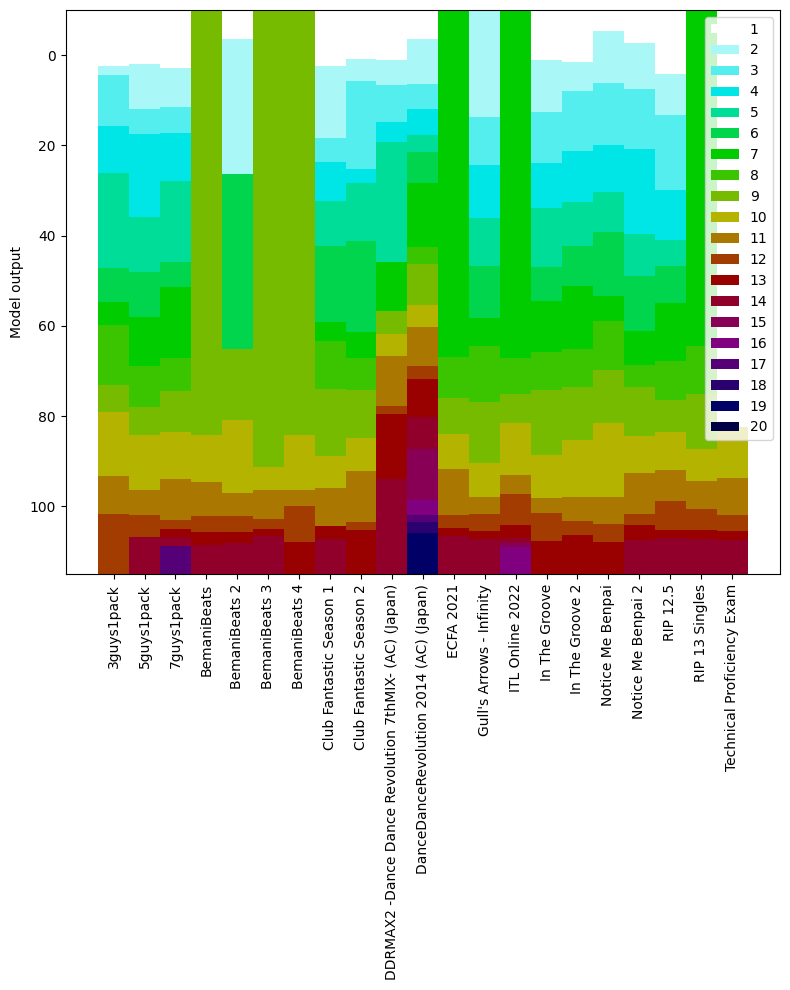

In [8]:
all_labels = [l1 for p, t, min_t, max_t, l in all_thresholds_and_labels for l1 in l]
min_label = max(min(all_labels), 1) # capped from below by 1  because of meme ratings
max_label = min(max(all_labels), 20)# capped from above by 16 because of meme ratings

#make a weird stairs plot that might not be stairs.
bars = np.zeros((max_label-min_label+2, len(all_thresholds_and_labels)), dtype=float)
bars -= 20
for i, (p, t, min_t, max_t, l) in enumerate(all_thresholds_and_labels):
    for j in range(len(t)):
        bars[l[j]-min_label+1,i]=t[j]

#fix bars, because some difficulties might not exist in a pack
for j in range(bars.shape[1]):
    for i in range(bars.shape[0]-1,-1,-1):
        if bars[i,j] == -20:
            bars[i,j] = 140
        else:
            break

for j in range(bars.shape[1]):
    last_t = -20
    for i in range(bars.shape[0]):
        if bars[i,j] == -20:
            bars[i,j] = last_t
        else:
            last_t = bars[i,j]

#visualize it
plt.rcParams["figure.figsize"] = (8,10)
plt.ylim(115,-10)
color_gradient = get_colors(len(bars)-1)
for i in range(len(bars)-1):
    plt.stairs(bars[i+1], baseline=bars[i], fill=True, label=str(i+min_label), color=color_gradient[i])
plt.legend()
plt.xticks([i+0.5 for i in range(len(all_thresholds_and_labels))], [p for p, t, min_t, max_t, l in all_thresholds_and_labels], rotation='vertical')
plt.ylabel('Model output')
plt.tight_layout()
try:
    os.makedirs('fig')
except:
    pass
plt.savefig('fig/test.png')

Now, this may confuse you. However, don't worry. I'm here to help. Probably some of your packs produce long, uniformly colored lines, and you are wondering why a 1 in one pack would be a 9 in another. Well, if you see long lines at the start or end of one pack, that is likely because that pack contains only some difficulties. Take, for instance, the pack BemaniBeats. This pack only includes difficulties 9-13, with an odd 420. How should I determine how difficulties 1-8 should be defined if they are absent? Exactly, I can't. So instead, I assume anything easier than the easiest chart in a pack should get the same label as that easiest chart, which in some cases might be a 9. The same holds for the opposite end of a pack, by the way.

## Visualizing Pack-Ranking Agreement

How about evaluating how strongly packs agree with my ranking? Using the optimal thresholds, I can assign each chart a new block difficulty, which can then be compared to its old one. The typical way to compare multiple of these is a confusion matrix. Which I do below for all the packs.

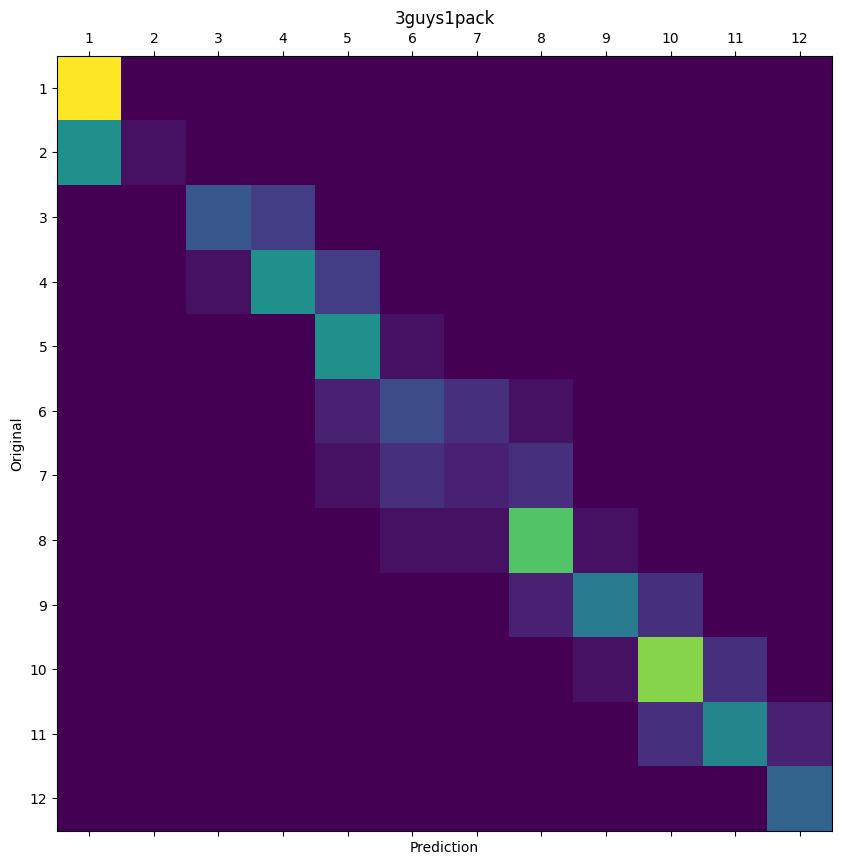

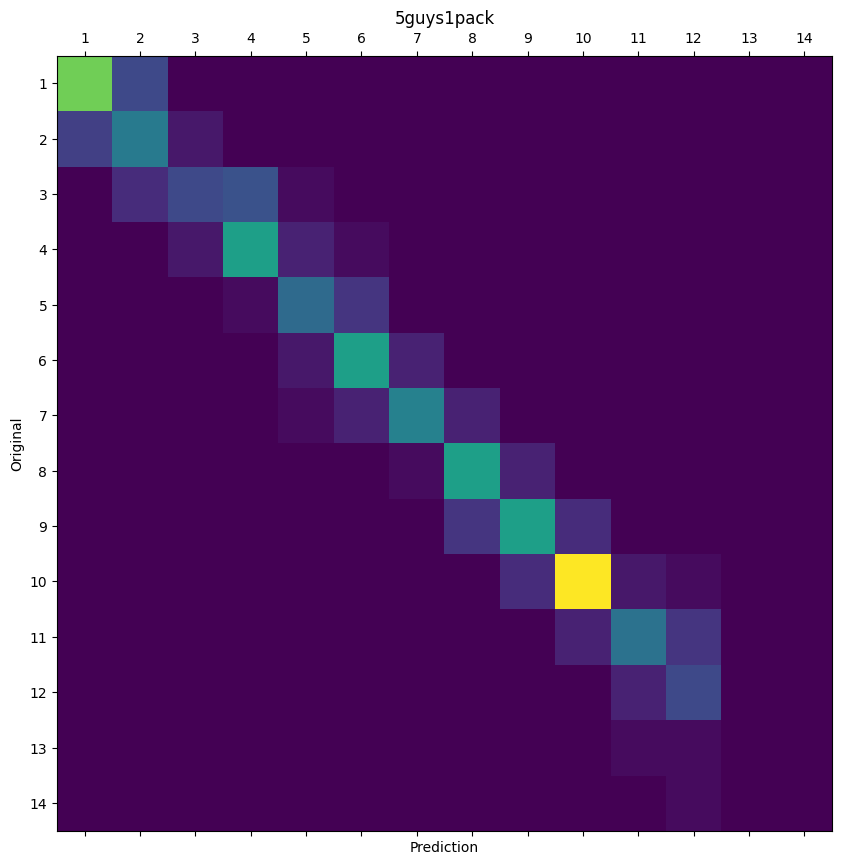

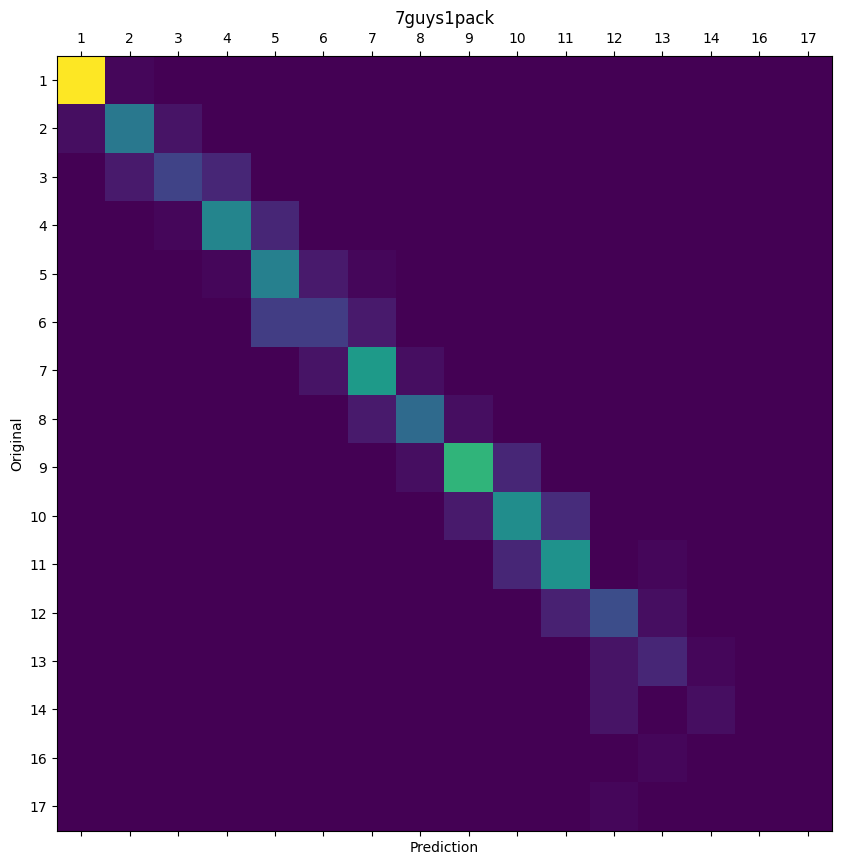

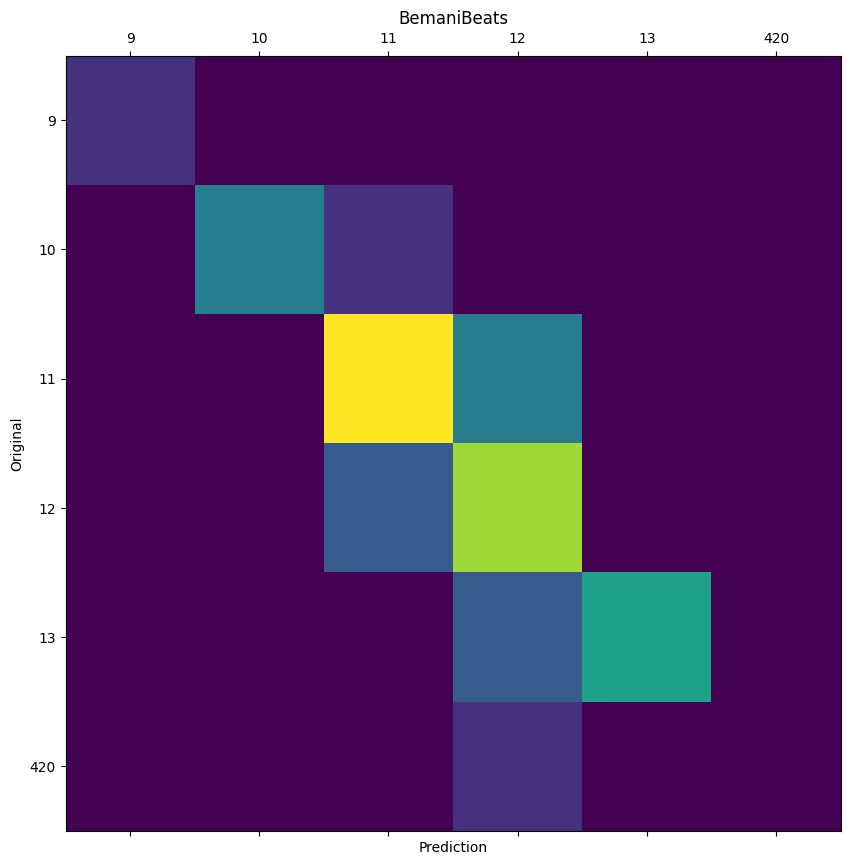

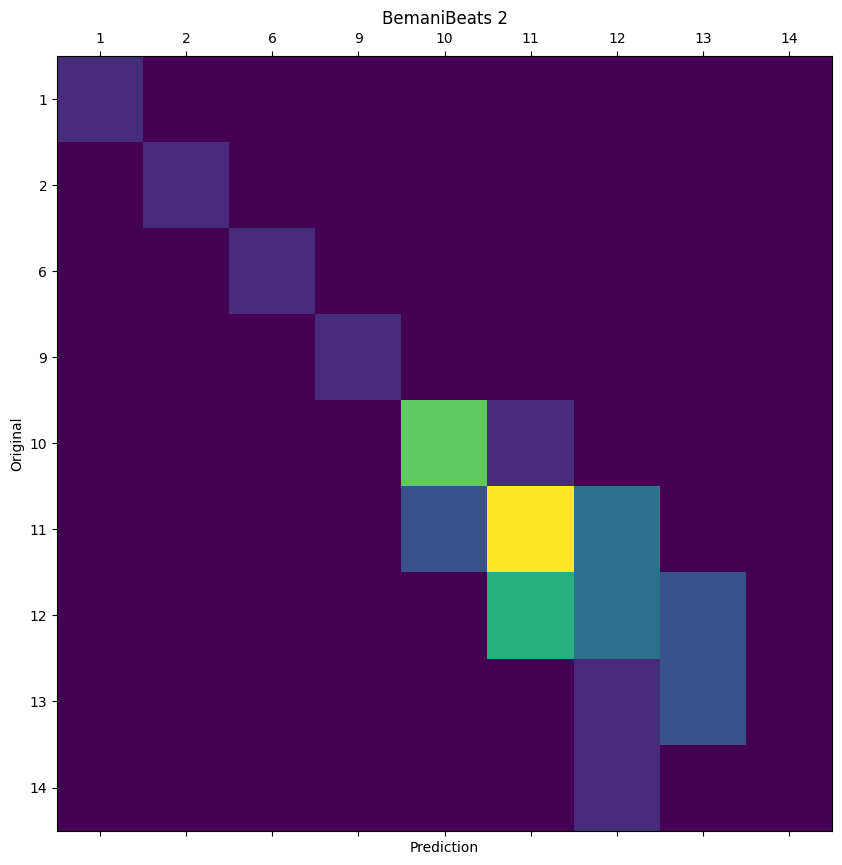

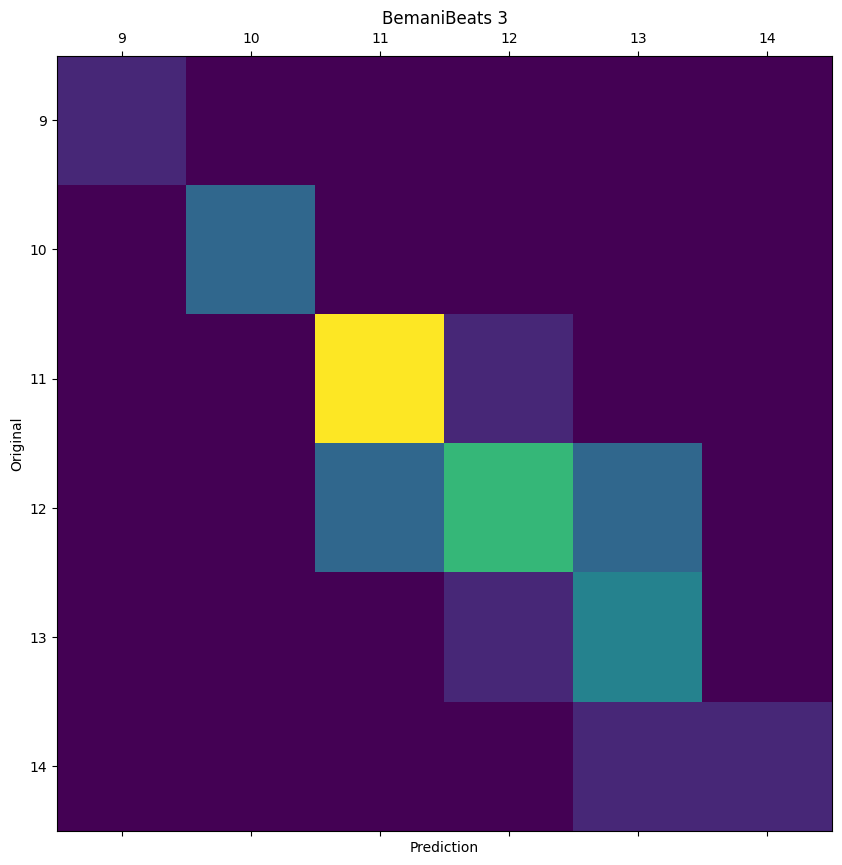

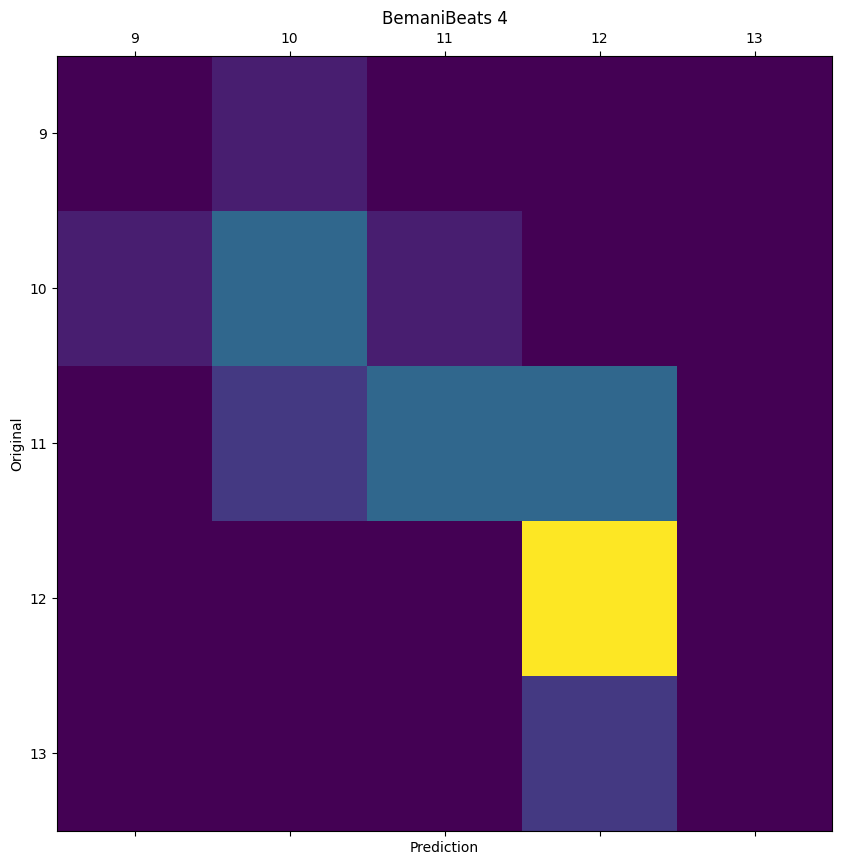

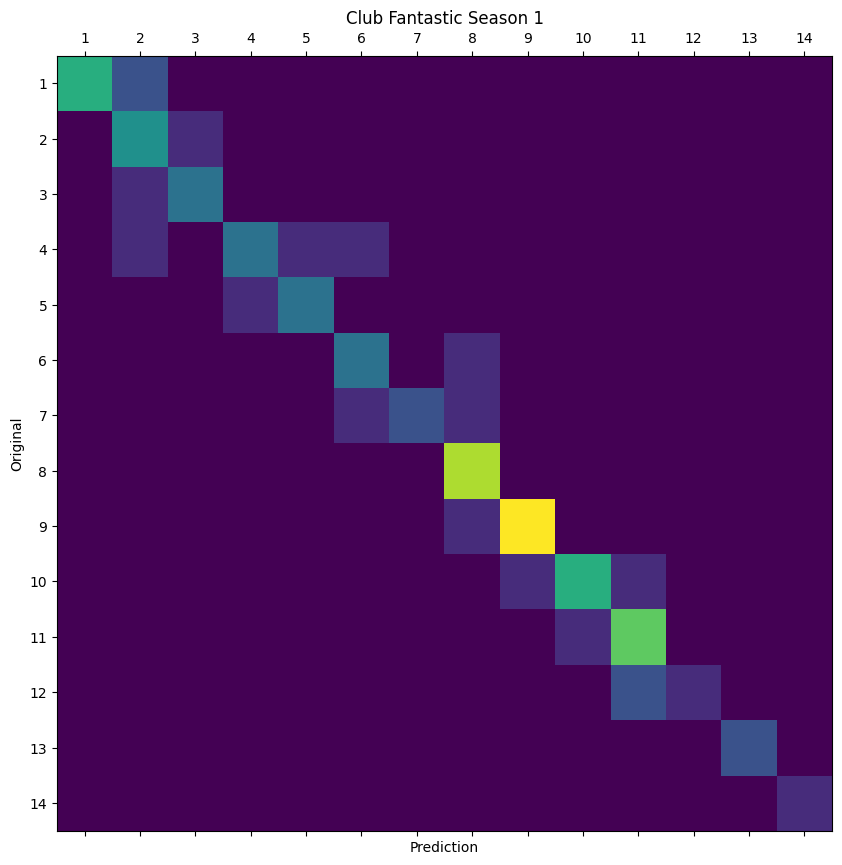

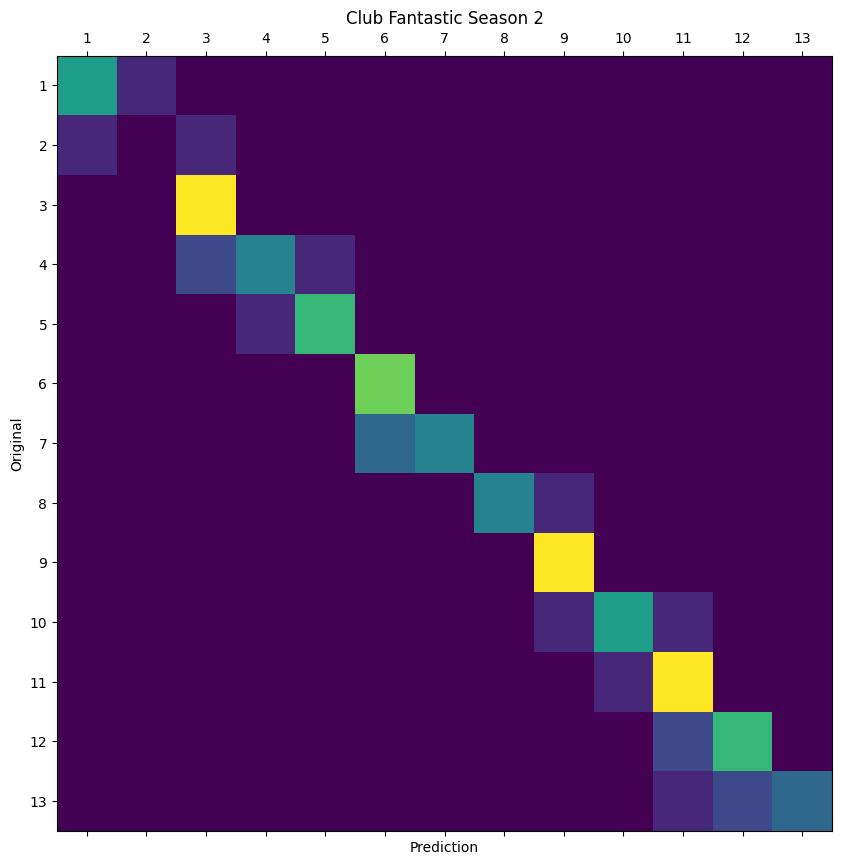

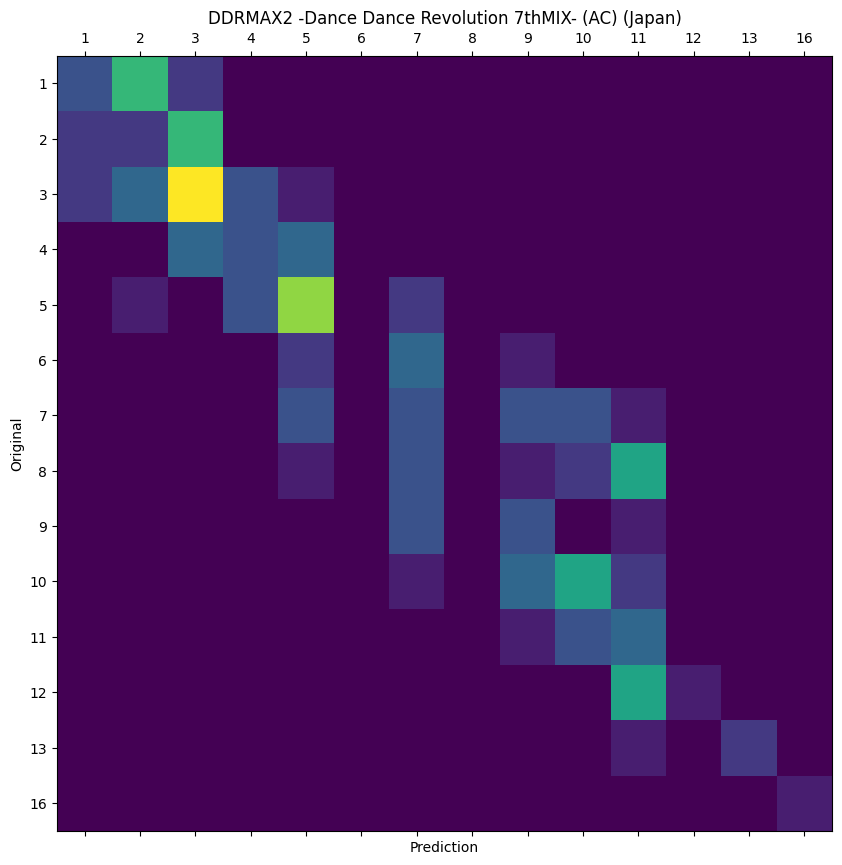

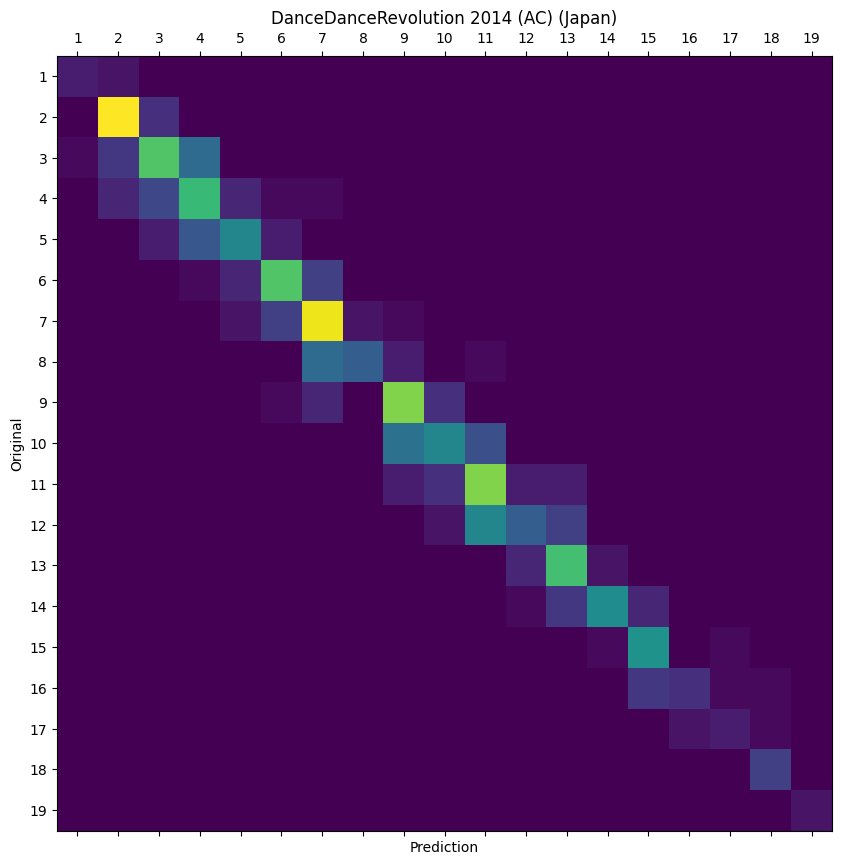

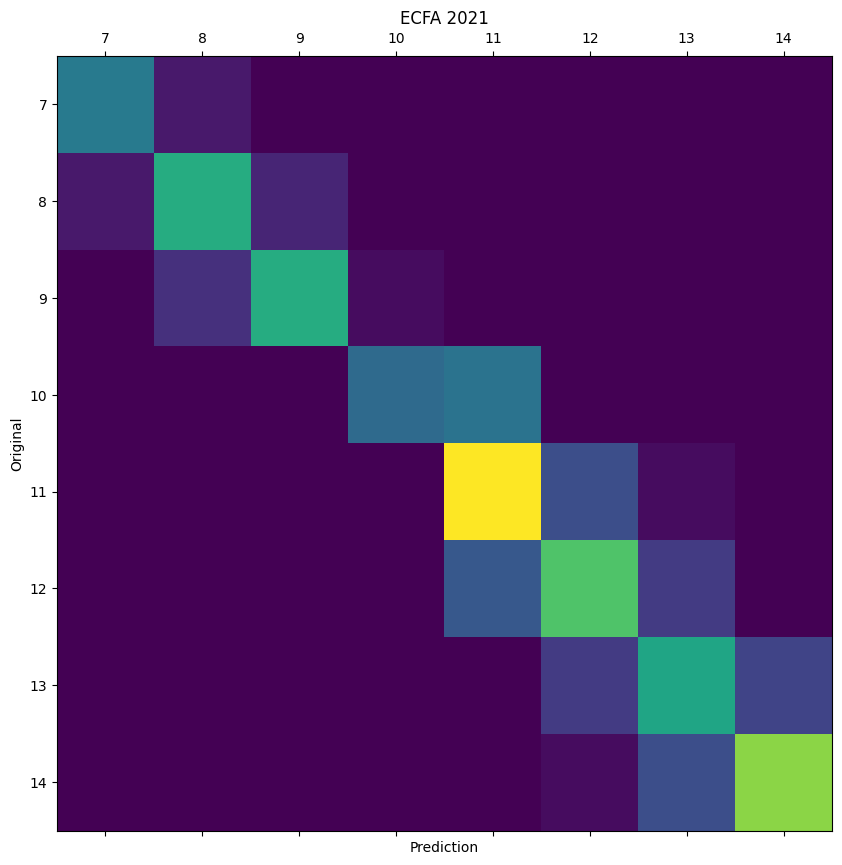

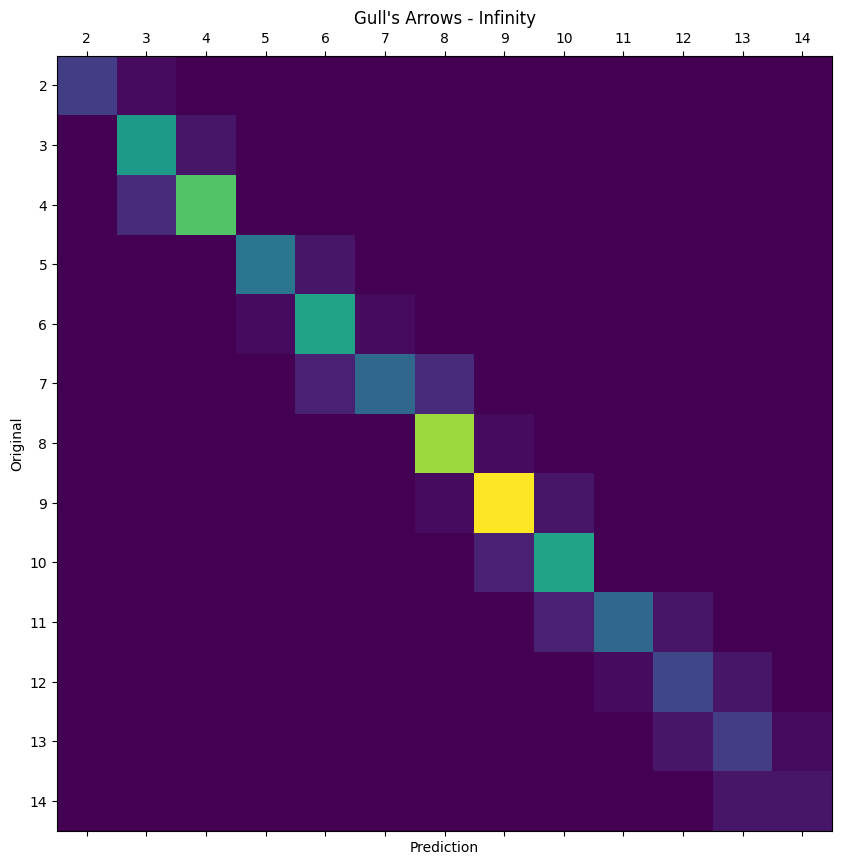

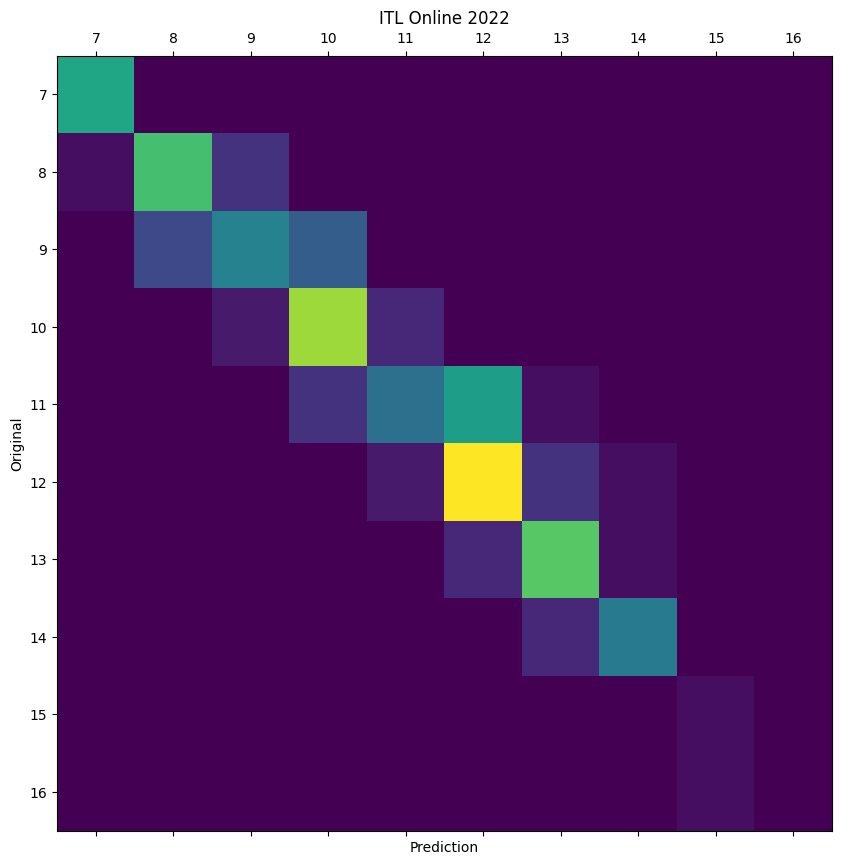

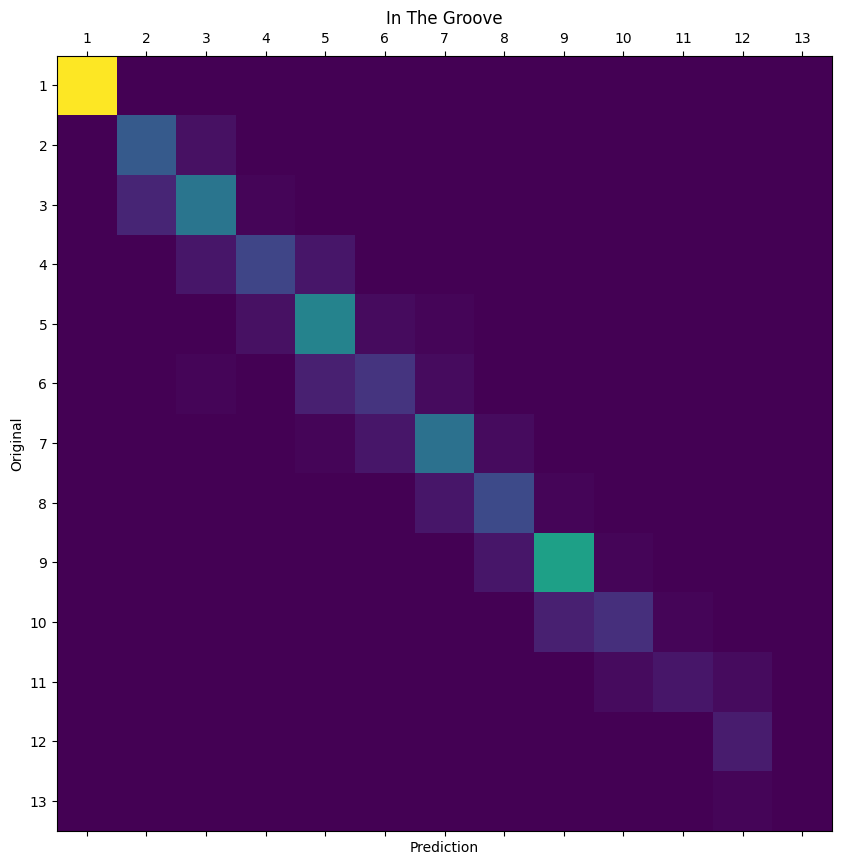

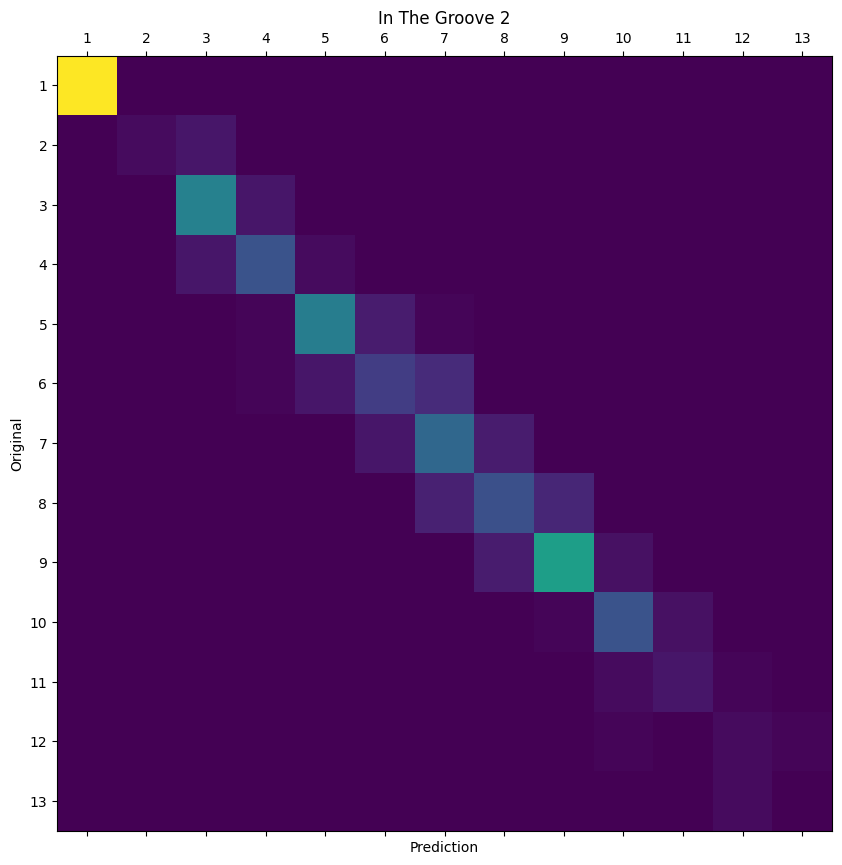

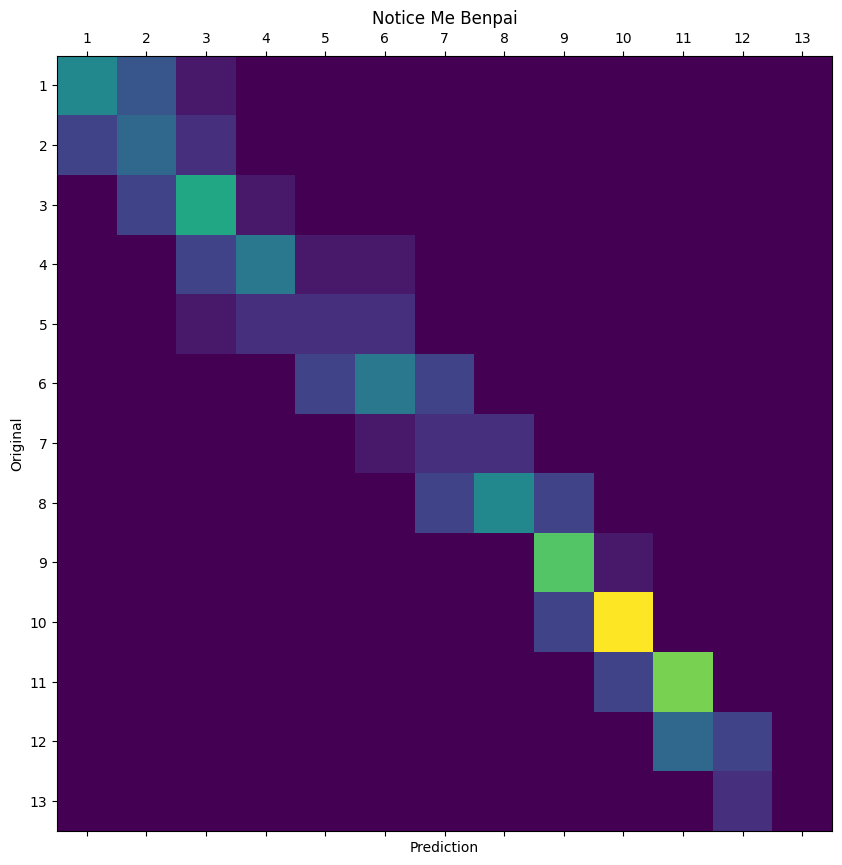

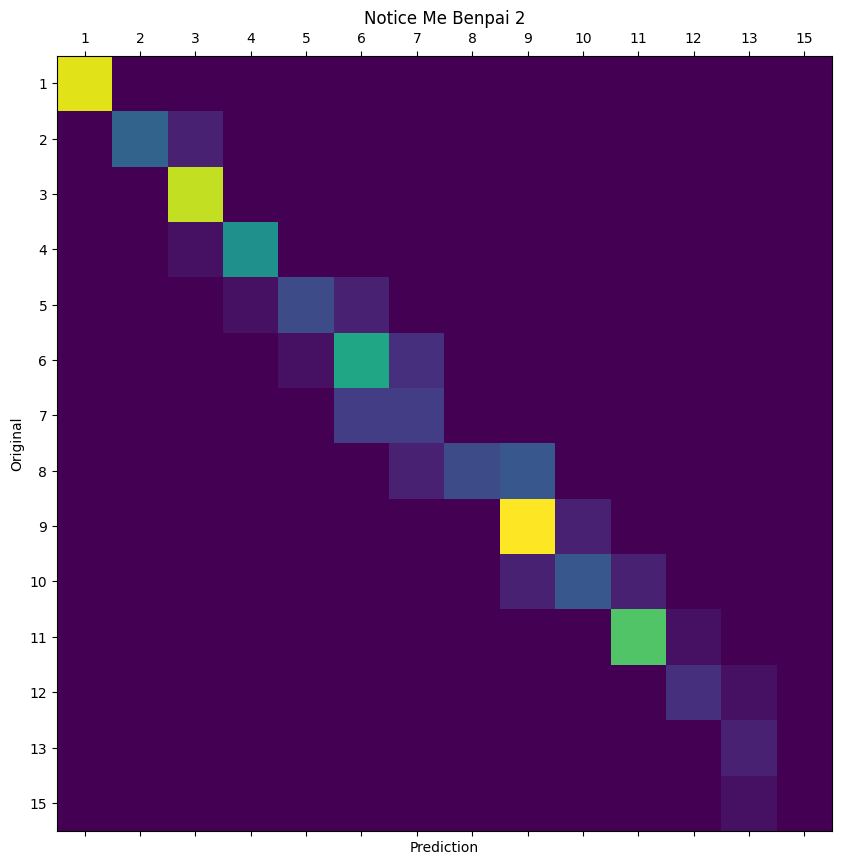

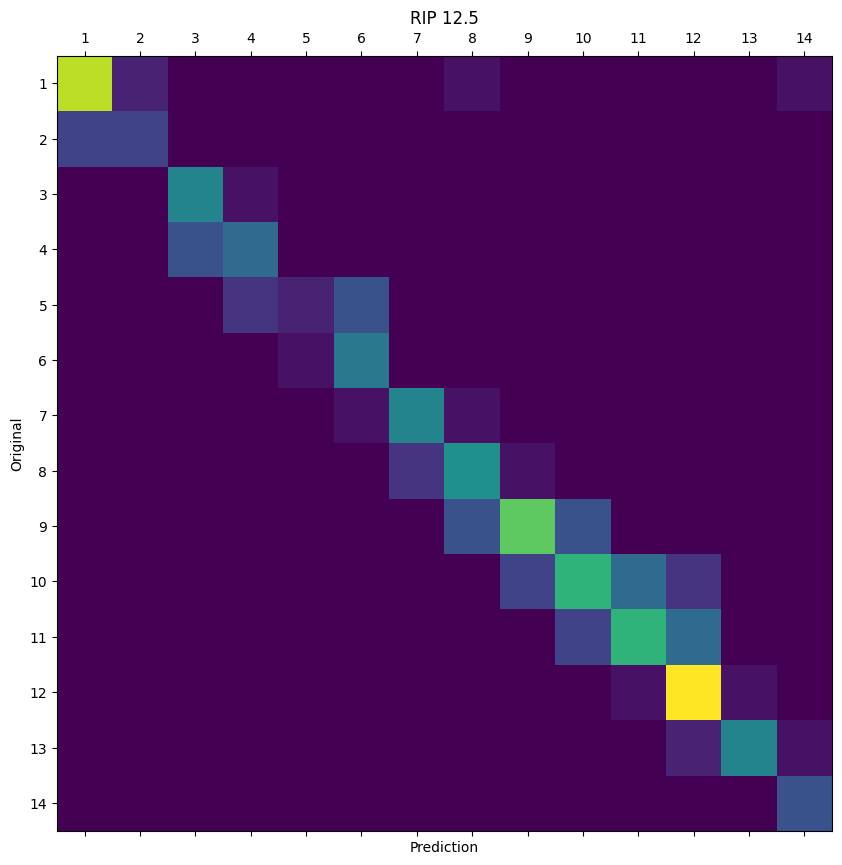

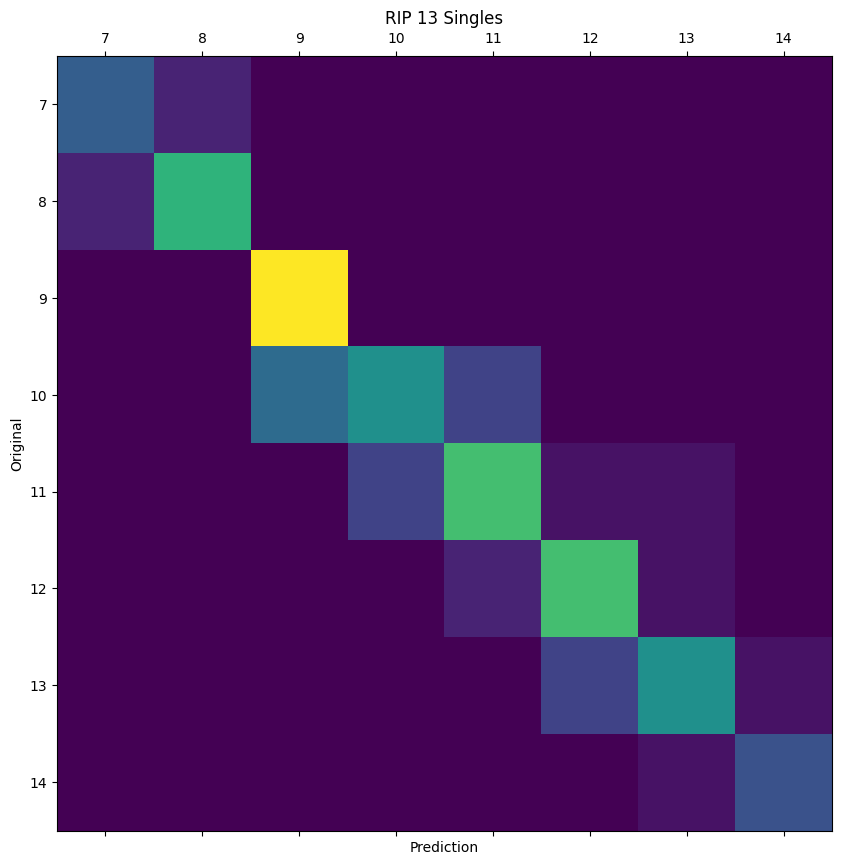

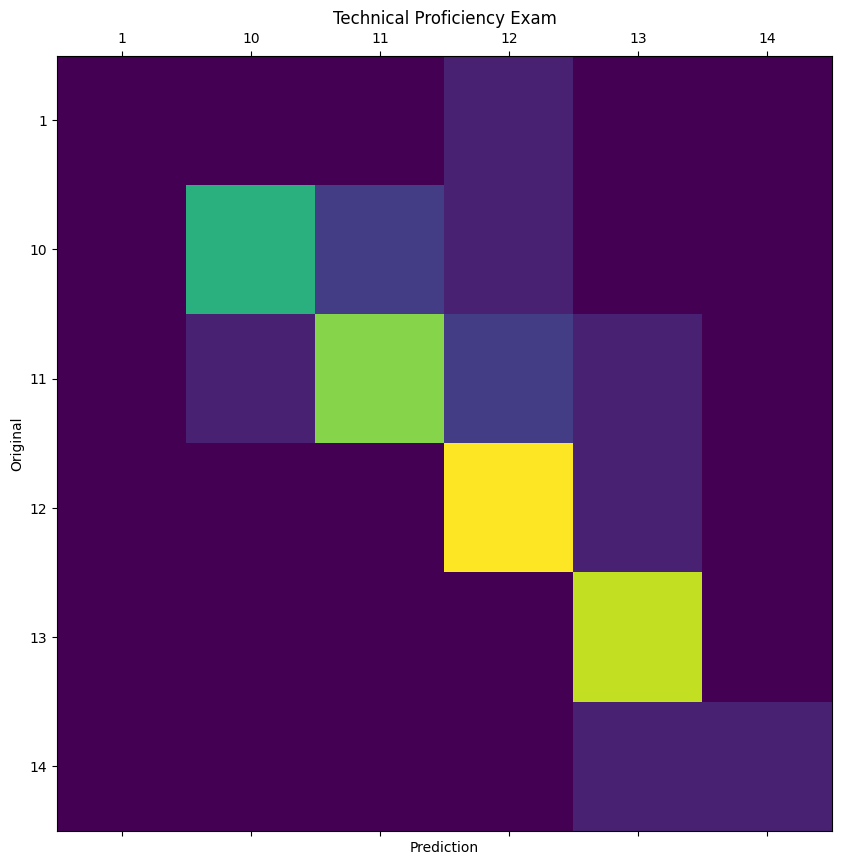

In [9]:
for pack_name, thresholds, min_thresholds, max_thresholds, labels in all_thresholds_and_labels:
    pack_name_charts = filter_for_pack(charts, pack_name)
    confusion_matrix = np.zeros((len(labels), len(labels)), dtype=int)
    for chart in pack_name_charts:
        prediction = len(thresholds)
        for i, t in enumerate(thresholds):
            if chart[0]<t:
                prediction = i
                break
        target = -1
        for i, l in enumerate(labels):
            if l==int(chart[3]):
                target = i
                break
        confusion_matrix[target][prediction] += 1
    plt.matshow(confusion_matrix)
    plt.xticks([i for i in range(len(labels))], labels)
    plt.xlabel('Prediction')
    plt.yticks([i for i in range(len(labels))], labels)
    plt.ylabel('Original')
    plt.title(pack_name)
    try:
        os.makedirs('fig')
    except:
        pass
    plt.savefig('fig/{}.png'.format(pack_name))
    plt.show()

That's about it. Can you think of more uses? Don't hesitate to contact my creator @Noodles (franks@cs.uni-kl.de) in that case.

I can also visualize the difficulty per time point within a chart. However, my creator is still working on making that work properly. I am still determining what the holdup is. He just always takes forever with these things.

## Difficulties Within a Chart

TODO